### atmospheric global mean biases

This is a diagnostic to get basic statistics from global atmospheric variables 

In [ ]:
from aqua import Reader, catalogue, inspect_catalogue
import sys
import os
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import calendar
%env PATH={os.environ["PATH"]}:{sys.exec_prefix}/bin/

In [5]:
plotdir = './plots/AtmGlobalBiases/'
if not os.path.exists(plotdir):
    os.makedirs(plotdir)

In [6]:
cat = catalogue()
inspect_catalogue(cat)

IFS	tco3999-ng5	2.8km experiment, coupled with FESOM
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- interpolated_global	NN interpolation to 5400x2700 grid (lon=[-180,180], lat=[-90, 90])
IFS	tco2559-ng5	4km experiment, coupled with FESOM
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- interpolated_global	NN interpolation to 5400x2700 grid (lon=[-180,180], lat=[-90, 90])
	- lra-r100-mon	LRA monthly data 1x1 deg regular grid
IFS	tco1279-orca025	9km baseline, coupled to NEMO, deep conv ON
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- lra-r100-mon	LRA monthly data 1x1 deg regular grid
IFS	test-tco2559	4km experiment, coupled with FESOM
	- ICMGG_atm2d	2d output
	- ICMU_atm3d	3d output
IFS	test-tco79	TCO79 test data
	- short	original 2d output
	- long	coarse IFS data 1y

FESOM	tco3999-ng5	2.5km experiment,

['IFS', 'FESOM', 'ICON', 'MSWEP', 'ERA5', 'CERES', 'AVISO', 'PHC3', 'WOA18']

In [4]:
reader_era5 = Reader(model="ERA5", exp="era5", source="monthly")
data_era5 = reader_era5.retrieve(fix=True)

reader_tco2559 = Reader(model = 'IFS', exp = 'tco2559-ng5', source = 'lra-r100-mon')
data_tco2559 = reader_tco2559.retrieve(fix=True)

reader_icon = Reader(model = 'ICON', exp = 'ngc2009', source = 'lra-r100-mon')
data_icon = reader_icon.retrieve(fix=True)

reader_tco1279 = Reader(model = 'IFS', exp = 'tco1279-orca025', source = 'lra-r100-mon')
data_tco1279 = reader_icon.retrieve(fix=True)

reader_fesom = Reader(model = 'FESOM', exp = 'tco2559-ng5', source = 'lra-r100-mon')
data_fesom = reader_tco2559.retrieve(fix=True)

In [5]:
#data_era5
data_tco2559
#data_icon
#data_tco1279

<xarray.Dataset>
Dimensions:  (time: 13, lat: 180, lon: 360, plev: 23)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-02-01 ... 2021-01-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * plev     (plev) float64 1e+05 9.75e+04 9.5e+04 ... 3e+03 1e+03 100.0
Data variables: (12/20)
    2t       (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    ci       (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    erate    (time, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    ewss     (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    hcc      (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    lcc      (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    ...       ...
    nsss     (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    q        (time, plev, lat, lon) float64 dask.array<chunksize=(12, 23, 180, 360), meta=np.ndarray>
    t        (time, plev, lat, lon) float64 dask.array<chunksize=(12, 23, 180, 360), meta=np.ndarray>
    tprate   (time, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    u        (time, plev, lat, lon) float64 dask.array<chunksize=(12, 23, 180, 360), meta=np.ndarray>
    v        (time, plev, lat, lon) float64 dask.array<chunksize=(12, 23, 180, 360), meta=np.ndarray>
Attributes:
    history:  2023-06-14 15:08:08 retrieved by AQUA retriever;\n2023-06-14 15...

In [45]:
label_tco1279 = '9km'
label_tco2559 = ' tco2559 4.5km'
label_tco3999 = '2.8km'
label_tco399  = 'tco399'
label_icon = 'icon 5km'

In [7]:
def compare_datasets(dataset1, dataset2, var1_name, var2_name, time_range, plev, statistic):
    # Get the variable name and unit for dataset1
    # var1_units = variable_mapping[dataset1][var1_name]
    
    # Get the variable name and unit for dataset2
    # var2_units = variable_mapping[dataset2][var2_name]
    
    # Select the desired variable from both datasets
    var1 = dataset1[var1_name]
    var2 = dataset2[var2_name]
    
    if dataset1 == 'data_tco2559':
        dataset1_name = 'tco2559'
    elif dataset1 =='data_era5':
        dataset1_name = 'ERA5'
    elif dataset1 == 'data_icon':
        dataset1_name ='ICON'
    elif dataset1 == 'data_tco1279':
        dataset1_name = 'tco1279'
    
    
    if dataset2 == 'data_tco2559':
        dataset2_name = 'tco2559'
    elif dataset2 =='data_era5':
        dataset2_name = 'ERA5'
    elif dataset2 == 'data_icon':
        dataset2_name = 'ICON'
    elif dataset2 == 'data_tco1279':
        dataset2_name = 'tco1279'
        
    # Convert units if necessary
    #  if var1_units != var2_units:
        # Perform unit conversion here
        # ...
   #     pass
    
    # Select the desired time range
    var1 = var1.sel(time=time_range)
    var2 = var2.sel(time=time_range)
    
    # Select the desired pressure level if provided
    if plev is not None:
        var1 = var1.sel(plev=plev)
        var2 = var2.sel(plev=plev)
    
    # Calculate the desired statistic for each month
    results = []
    for month in var1.time.dt.month:
        var1_month = var1.sel(time=var1.time.dt.month == month)
        var2_month = var2.sel(time=var2.time.dt.month == month)
        if statistic == 'mean':
            result_month = var2_month.mean(dim='time') - var1_month.mean(dim='time')
        elif statistic == 'max':
            result_month = var2_month.max(dim='time') - var1_month.max(dim='time')
        elif statistic == 'min':
            result = (var1.min(dim='time'), var2.min(dim='time'))
        elif statistic == 'diff':
            result = (var1 - var2)
        elif statistic == 'std':
            result = (var1.std(dim='time'), var2.std(dim='time'))
        else:
            raise ValueError("Invalid statistic. Please choose one of 'mean', 'std', 'max', 'min', or 'diff'.")
        results.append(result_month)
    
               
     # Plot the bias maps for each month
    fig, axs = plt.subplots(len(results), figsize=(7, 3 * len(results)))  
    if len(results) == 1:
        axs = [axs]  # Convert axs to a list if only one plot
    for i, result in enumerate(results):
        ax = axs[i]
        cnplot = result.plot(ax=ax, cmap='RdBu_r', vmin=-10, vmax=10)
        # Add a single color bar for all subplots
        #cbar_label = f'{var1.units}'  # Unit label for color bar
        #fig.colorbar(cnplot, ax=axs, label=cbar_label, shrink =0.3)
        #cbar = fig.colorbar(cnplot, ax=ax)
        #cbar.set_label(f'{var1.units}', rotation=270, labelpad=15)
        #result.plot(ax=ax, cmap='RdBu_r', vmin=-10, vmax=10)
        #month_name = dataset1.time[i].dt.strftime('%B')
        ax.set_title(f'Bias of {var2_name} ({dataset2[var2_name].long_name}) [{var2.units}] ({statistic}) at {plev} Pa\n Experiment with respect to ERA5 Month {i+1}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        fig.subplots_adjust(right=0.95)
        
    #plotlevels=np.arange(-50,51,10)
    global small_fonts
    small_fonts = 8
   
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)  # Adjust the spacing as desired
    
    # Save the figure as a PNG file

    plt.savefig(plotdir+'1_'+dataset1_name+'_AtmosphericGlobalBiases_'+var1_name+'.png',dpi=300, facecolor='white')

    return results, axs


Checking and calling the function for several variables for the first three months of 2020

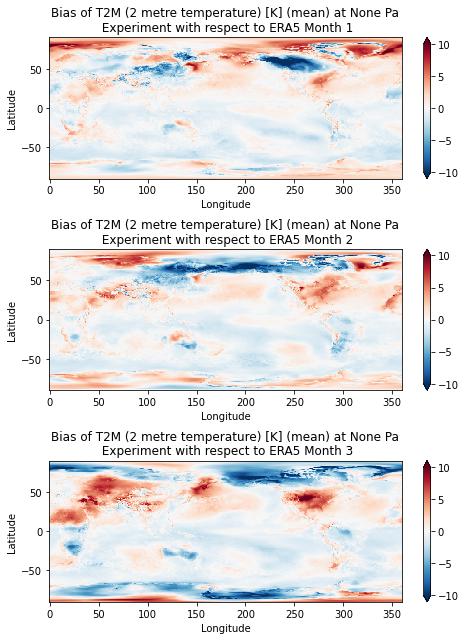

In [12]:
# Call function for Temperature Biases
result, bias_map = compare_datasets(data_tco2559, data_era5, '2t', 'T2M', slice('2020-01-01', '2020-03-01'), plev = None, statistic = 'mean')

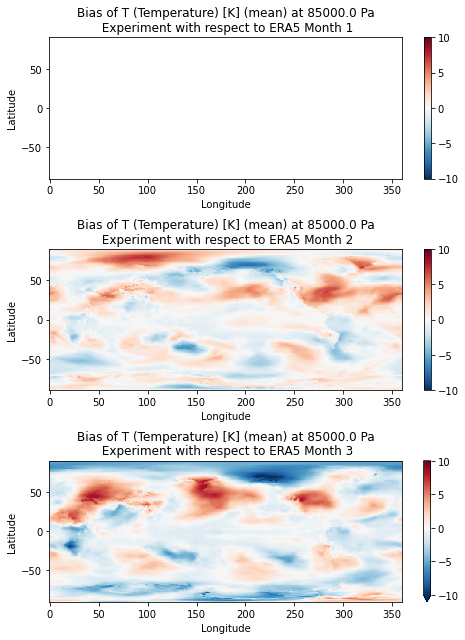

In [13]:
result, bias_map = compare_datasets(data_tco2559, data_era5, 't', 'T', slice('2020-01-01', '2020-03-01'), plev = 85000.0, statistic = 'mean')

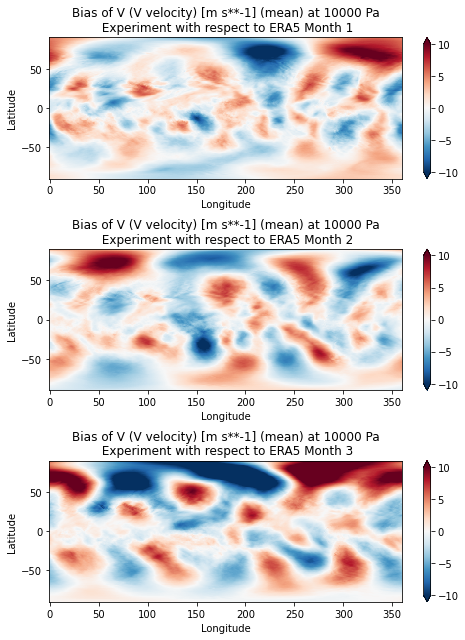

In [14]:
result, bias_map = compare_datasets(data_tco2559, data_era5, 'v', 'V', slice('2020-01-01', '2020-03-01'), plev = 10000, statistic = 'mean')

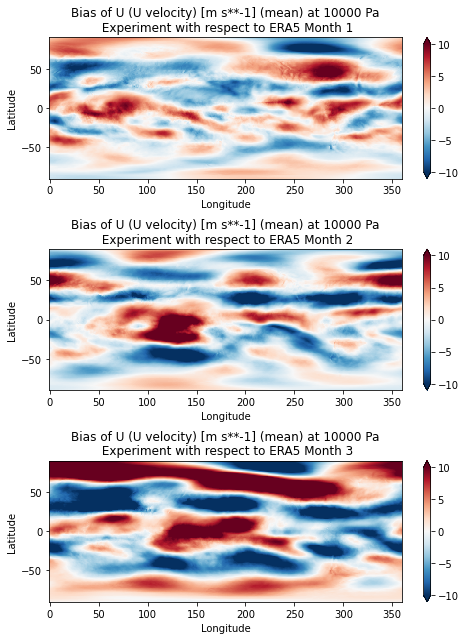

In [334]:
result, bias_map = compare_datasets(data_tco2559, data_era5, 'u', 'U', slice('2020-01-01', '2020-03-01'), plev = 10000, statistic = 'mean')

#### Zonal plots

#### Line plots

preparing the data first and calculating global means of the respective variables

In [76]:
#-------get global means for 2t ---------------

weights = np.cos(np.deg2rad(data_tco2559.lat))
tco_2t = data_tco2559['2t']
tco2559_weighted_t2m = tco_2t.weighted(weights)
tco2559_gm_t2m = tco2559_weighted_t2m.mean(('lon', 'lat'))

weights = np.cos(np.deg2rad(data_era5.lat))
era5_2t = data_era5['T2M'].sel(time=slice('2020-01-01', '2020-12-01'))
era5_weighted_t2m = era5_2t.weighted(weights)
era5_gm_t2m = era5_weighted_t2m.mean(('lon', 'lat'))

weights = np.cos(np.deg2rad(data_icon.lat))
icon_2t_gm = data_icon['2t'].sel(time=slice('2020-01-01', '2020-12-01'))
icon_weighted_t2m = icon_2t_gm.weighted(weights)
icon_gm_t2m = icon_weighted_t2m.mean(('lon', 'lat'))

#-------get global means for q 1000 hpa ---------------

weights = np.cos(np.deg2rad(data_tco2559.lat))
tco_q = data_tco2559['q'].sel(plev=100000)
tco2559_weighted_q = tco_q.weighted(weights)
tco2559_gm_q = tco2559_weighted_q.mean(('lon', 'lat'))

weights = np.cos(np.deg2rad(data_era5.lat))
era5_q = data_era5['Q'].sel(time=slice('2020-01-01', '2020-12-01'), plev = 100000)
era5_weighted_q = era5_q.weighted(weights)
era5_gm_q = era5_weighted_q.mean(('lon', 'lat'))

#-------get global means for q 500 hpa ---------------

weights = np.cos(np.deg2rad(data_era5.lat))
era5_q_500hpa = data_era5['Q'].sel(time=slice('2020-01-01', '2020-12-01'), plev = 50000)
era5_weighted_q_500hpa = era5_q_500hpa.weighted(weights)
era5_gm_q_500hpa = era5_weighted_q_500hpa.mean(('lon', 'lat'))

weights = np.cos(np.deg2rad(data_tco2559.lat))
tco_q_500hpa = data_tco2559['q'].sel(plev=50000)
tco2559_weighted_q_500hpa = tco_q_500hpa.weighted(weights)
tco2559_gm_q_500hpa = tco2559_weighted_q_500hpa.mean(('lon', 'lat'))

# no q for icon dataset
# weights = np.cos(np.deg2rad(data_icon.lat))
# icon_2t_q = data_icon['q'].sel(time=slice('2020-01-01', '2020-12-01'))
# icon_weighted_q = icon_q.weighted(weights)
# icon_gm_q = icon_weighted_q.mean(('lon', 'lat'))

Adding more experiments soon; variable check. more plevels?

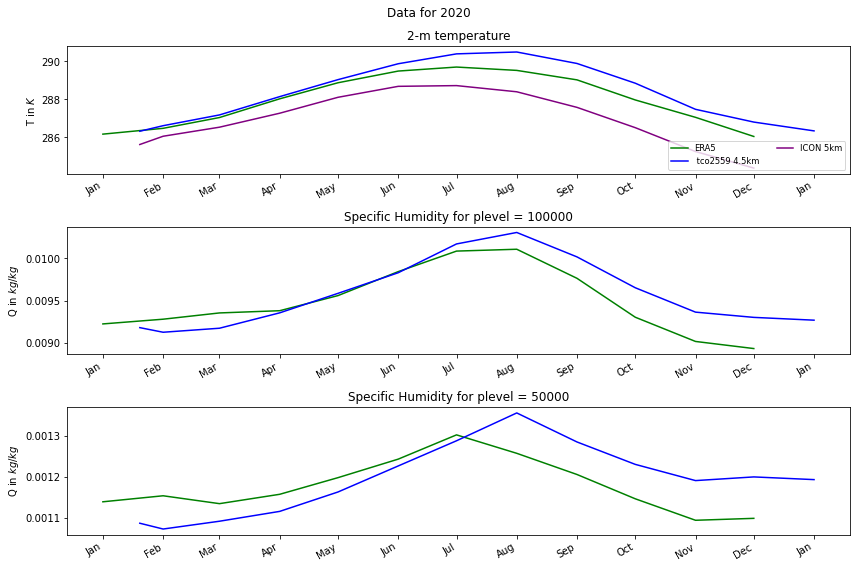

In [77]:
fig, axes = plt.subplots(3, 1,figsize=(12,8))
import matplotlib.dates as mdates
# panel Temperature
era5_gm_t2m.plot(ax=axes[0],color='green',label='ERA5',x='time')
tco2559_gm_t2m.plot(ax=axes[0],color='blue',label=label_tco2559,x='time')
icon_gm_t2m.plot(ax=axes[0],color='purple',label='ICON 5km',x='time')

axes[0].set_ylabel('T in $K$')
axes[0].set_title('2-m temperature')
axes[0].set_xticklabels([])
axes[0].set_xlabel('')
#axes[0].set_xlim(['2020-01-01','2020-12-31'])
# Set the x-axis locator and formatter for months for each subplot
for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
axes[0].legend(loc="lower right",frameon=True,fontsize='small',ncol=2)

# # panel sp. humidity
era5_gm_q.plot(ax=axes[1],color='green',label='ERA5',x='time')
tco2559_gm_q.plot(ax=axes[1],color='blue',label=label_tco2559,x='time')
# #TOA_tco3999_gm.tsr.plot(ax=axes[1],color='cyan',label=label_tco3999,x='time')
# icon_5km_gm.tsr.plot(ax=axes[1],color='purple',label='ICON 5km',x='time')
#ceres_global_mean_sw_2020.plot(ax=axes[1],color='black',label='ceres-ebaf',x='time')

axes[1].set_ylabel('Q in $kg/kg$')
axes[1].set_title('Specific Humidity for plevel = 100000')
axes[1].set_xticklabels([])
axes[1].set_xlabel('')
#axes[1].set_xlim(['2020-01-01','2021-12-31'])
for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# # panel tprate
era5_gm_q_500hpa.plot(ax=axes[2],color='green',label=label_icon,x='time')
tco2559_gm_q_500hpa.plot(ax=axes[2],color='blue',label=label_tco2559,x='time')

axes[2].set_ylabel('Q in $kg/kg$')
axes[2].set_title('Specific Humidity for plevel = 50000')
axes[2].set_xticklabels([])
axes[2].set_xlabel('')
#axes[1].set_xlim(['2020-01-01','2021-12-31'])
for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))


plt.suptitle('Data for 2020')
plt.tight_layout()
plt.savefig(plotdir+'LinePlot_AtmosphericGlobalBiases.png',dpi=300, facecolor='white')

#plt.savefig(plotdir+'TOA_global_mean_tco1279_tco2559_icon5km_CERES.png',dpi=300)

#### This function serves to get vector plots from windspeeds
##### right now only avail. for IFS tco2559 (?)

In [320]:
#data_era5['MSL'][960,:,:].plot()

In [272]:
def compare_wind_velocity(ds1, u_1, v_1, ds2, u_2, v_2, plev, start_time, end_time, colormap='jet'):
    # Create the figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6),
                                   subplot_kw={'projection': ccrs.PlateCarree()})
    fig.subplots_adjust(wspace=0.2)

# Plot for dataset 1
    ax1.coastlines()
    ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray',
                  xlocs=range(-180, 180, 30), ylocs=range(-90, 90, 30))
    ax1.set_title('Wind velocity - Dataset 1', fontsize=10, fontweight='bold')

# Extract the wind velocity components and calculate magnitude for dataset 1
    u_ds1 = ds1[u_1].sel(plev=plev, time=slice(start_time, end_time))
    v_ds1 = ds1[v_1].sel(plev=plev, time=slice(start_time, end_time))
    magnitude1 = np.sqrt(u_ds1**2 + v_ds1**2)

# Plot the wind vectors for dataset 1
    inc = 3
    vec1 = ax1.quiver(ds1.lon[::inc], ds1.lat[::inc],
                      u_ds1[0, ::inc, ::inc],
                      v_ds1[0, ::inc, ::inc],
                      magnitude1[0, ::inc, ::inc],
                      cmap=colormap,
                      transform=ccrs.PlateCarree())

# Add colorbar for dataset 1
    cbar1 = plt.colorbar(vec1, ax=ax1, pad=0.07, shrink=0.55)
    cbar1.set_label('Wind magnitude (m/s)', labelpad=15, y=.5, rotation=90)

# Plot for dataset 2 (similar to dataset 1)
    ax2.coastlines()
    ax2.gridlines(draw_labels=True, linewidth=0.5, color='gray',
                  xlocs=range(-180, 180, 30), ylocs=range(-90, 90, 30))
    ax2.set_title('Wind velocity - Dataset 2', fontsize=10, fontweight='bold')

    u_ds2 = ds2[u_2].sel(plev=plev, time=slice(start_time, end_time))
    v_ds2 = ds2[v_2].sel(plev=plev, time=slice(start_time, end_time))
    magnitude2 = np.sqrt(u_ds2**2 + v_ds2**2)

    inc = 3
    vec2 = ax2.quiver(ds2.lon[::inc], ds2.lat[::inc],
                      u_ds2[0, ::inc, ::inc],
                      v_ds2[0, ::inc, ::inc],
                      magnitude2[0, ::inc, ::inc],
                      cmap=colormap,
                      transform=ccrs.PlateCarree())

    cbar2 = plt.colorbar(vec2, ax=ax2, pad=0.07, shrink=0.55)
    cbar2.set_label('Wind magnitude (m/s)', labelpad=15, y=.5, rotation=90)
    
    
    bias = ds1[u_1] - ds2[u_2], ds1[v_1] - ds2[v_2]
    magnitude_bias = np.sqrt(bias[0]**2 + bias[1]**2)
     # Plotting Bias
    magnitude_bias = np.sqrt(bias[0][0, ::inc, ::inc, 0]**2 + bias[1][0, ::inc, ::inc, 0]**2)
    vec_bias = ax1.quiver(ds1.lon[::inc], ds1.lat[::inc],
                          bias[0][0, ::inc, ::inc, 0],
                          bias[1][0, ::inc, ::inc, 0],
                          magnitude_bias,
                          cmap=colormap,
                          transform=ccrs.PlateCarree())
    ax1.set_title('Wind velocity Bias', fontsize=10, fontweight='bold')
    

    plt.show()

In [2]:
#compare_wind_velocity(data_tco2559, 'u', 'v', data_era5, 'U', 'V', plev=1000, start_time = '2020-01-01', end_time = '2020-01-31')

#### Creating seasonal plots for each of the variables